In [2]:
import pandas as pd
import networkx as nx
import osmnx as ox
import config
import random
import math
import testing.helpers.testing_helper as test_helper
import route_planning.helpers.route_planning_helper as route_helper
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
G = ox.load_graphml(filepath=f"{config.testing_graphml_path}/merged_routes.graphml")
G

Get sets of generated and real bus stops

In [4]:
%%time
nodes, edges = ox.graph_to_gdfs(G)
nodes = nodes.replace({"True": True, "False": False})
actual_stops = nodes[nodes["actual_stop"] == True]
generated_stops = nodes[(nodes["community_route"] == True) |
                        (nodes["connection_route"] == True)]

CPU times: user 871 ms, sys: 10.2 ms, total: 881 ms
Wall time: 884 ms


In [5]:
len(actual_stops)

122

In [6]:
len(generated_stops)

650

Determine sample size to use...

First find the total population:

In [7]:
population_data = pd.read_csv(f"{config.population_data_path}/donegal_townlands_all_coordinates.csv")
total_population = sum(population_data["population"])
total_population

157920.0

And use that number for the Cochran’s theorem calculation:

In [8]:
sample_size = test_helper.sample_size(int(total_population),
                                      margin_error=.05,
                                      confidence_level=.95)
sample_size

383.23017177926187

Round sample size up to 384

In [9]:
sample_size = math.ceil(sample_size)
sample_size

384

Select pseudorandom sample nodes

In [22]:
random.seed(20201)
all_stops = actual_stops["osmid"].tolist() + generated_stops["osmid"].tolist()
nodes_to_sample_from = nodes.query("osmid not in @all_stops")["osmid"].tolist()
%time sample_nodes = random.sample(nodes_to_sample_from, sample_size)
sample_nodes

CPU times: user 308 µs, sys: 20 µs, total: 328 µs
Wall time: 333 µs


[1885999711,
 7652324655,
 3108348650,
 1901973547,
 1963751739,
 7637762280,
 1887467735,
 2196541606,
 6267753315,
 4415781286,
 2111585042,
 3923722491,
 2250284775,
 3079530461,
 773127127,
 6988356802,
 1883215192,
 2115650492,
 2295823930,
 1898351504,
 6699852206,
 3201463827,
 4358945120,
 2907574087,
 1947634476,
 2138724650,
 5290767790,
 1889048433,
 703791266,
 4303368910,
 1878490517,
 4422544245,
 7154615557,
 3151921681,
 795277445,
 1947634669,
 3686164230,
 1954997786,
 1963790305,
 458512262,
 2196517605,
 2197729959,
 1918855038,
 821215165,
 816390364,
 790572164,
 2195641221,
 3585606117,
 1912613530,
 2679280872,
 3111568920,
 818366899,
 5431750851,
 2815549301,
 7622272147,
 336115536,
 1925725144,
 816381831,
 1799569118,
 3336948892,
 7490258570,
 258455072,
 1734596366,
 2112562728,
 821231810,
 2426821816,
 1883219693,
 1956336238,
 528692214,
 1932681060,
 2278837115,
 2912764832,
 1930345490,
 6715318507,
 3749413314,
 1696502244,
 2113423991,
 795277769,


Run the accessibility tests:

In [23]:
%%time

results_list = []
for node in sample_nodes:
    # 20km radius graph around the source node
    graph = nx.generators.ego_graph(G, node, radius=20000, distance="length")

    # get the stops that are in the sub-graph
    nodes = ox.graph_to_gdfs(graph, edges=False)
    nodes = nodes.replace({"True": True, "False": False})
    actual_stops_present = list(set(actual_stops["osmid"]).intersection(nodes["osmid"]))
    gen_stops_present = list(set(generated_stops["osmid"]).intersection(nodes["osmid"]))

    # path to closest actual stop
    actual_stops_shortest_path, actual_stops_shortest_path_weight = \
    test_helper.find_shortest_path_to_destinations(graph,
                                                   node,
                                                   actual_stops_present,
                                                   print_all=False)
    # path to closest generated stop
    gen_stops_shortest_path, gen_stops_shortest_path_weight = \
    test_helper.find_shortest_path_to_destinations(graph,
                                                   node,
                                                   gen_stops_present,
                                                   print_all=False)

    # add to results
    results_list.append({"sample_node": node,
                         "actual_stops_sp": actual_stops_shortest_path,
                         "actual_stops_sp_length": actual_stops_shortest_path_weight,
                         "gen_stops_sp": gen_stops_shortest_path,
                         "gen_stops_sp_length": gen_stops_shortest_path_weight})
results_df = pd.DataFrame(results_list)
results_df

CPU times: user 10min 33s, sys: 629 ms, total: 10min 33s
Wall time: 10min 37s


,sample_node,actual_stops_sp,actual_stops_sp_length,gen_stops_sp,gen_stops_sp_length
0,1885999711,"[1885999711, 1963792140, 1256131968, 125613182...",522.940,"[1885999711, 1885999741, 1279692712, 300886254...",1496.120
1,7652324655,"[7652324655, 7637844081, 258431322, 278187049,...",3374.292,"[7652324655, 7637844081, 7637857698, 763784407...",2840.187
2,3108348650,"[3108348650, 1625516019, 1625516015, 187739620...",11124.753,"[3108348650, 1625516019, 1625516015]",61.922
3,1901973547,"[1901973547, 458514915, 458514922, 1956288757,...",4680.462,"[1901973547, 458514915, 458514922]",758.687
4,1963751739,"[1963751739, 1963751821, 1963751829, 300885657...",1486.372,"[1963751739, 1963751821, 1963751829, 300885657...",2449.926
...,...,...,...,...,...
379,2811152804,"[2811152804, 2811152074, 258431385, 2811152839...",5595.471,"[2811152804, 258431404, 2811152889, 2811152819...",4550.511
380,1411714716,"[1411714716, 1411702929, 1411702990, 141170292...",598.275,"[1411714716, 1411702929, 1411702990, 141170292...",598.275
381,1880487032,"[1880487032, 1880798719, 1877528011, 188048685...",2040.957,"[1880487032, 1880798719]",45.947
382,3306903561,"[3306903561, 3306903577, 3306903627, 330690365...",479.900,"[3306903561, 3306903577, 3306903627, 330690365...",5041.721


In [24]:
results_df.to_csv(f"{config.testing_path}/"
                  f"results/test_results.csv")

In [45]:
results_df = pd.read_csv(f"{config.testing_path}/"
                         f"results/test_results.csv")
results_df

,Unnamed: 0,sample_node,actual_stops_sp,actual_stops_sp_length,gen_stops_sp,gen_stops_sp_length
0,0,1885999711,"[1885999711, 1963792140, 1256131968, 125613182...",522.940,"[1885999711, 1885999741, 1279692712, 300886254...",1496.120
1,1,7652324655,"[7652324655, 7637844081, 258431322, 278187049,...",3374.292,"[7652324655, 7637844081, 7637857698, 763784407...",2840.187
2,2,3108348650,"[3108348650, 1625516019, 1625516015, 187739620...",11124.753,"[3108348650, 1625516019, 1625516015]",61.922
3,3,1901973547,"[1901973547, 458514915, 458514922, 1956288757,...",4680.462,"[1901973547, 458514915, 458514922]",758.687
4,4,1963751739,"[1963751739, 1963751821, 1963751829, 300885657...",1486.372,"[1963751739, 1963751821, 1963751829, 300885657...",2449.926
...,...,...,...,...,...,...
379,379,2811152804,"[2811152804, 2811152074, 258431385, 2811152839...",5595.471,"[2811152804, 258431404, 2811152889, 2811152819...",4550.511
380,380,1411714716,"[1411714716, 1411702929, 1411702990, 141170292...",598.275,"[1411714716, 1411702929, 1411702990, 141170292...",598.275
381,381,1880487032,"[1880487032, 1880798719, 1877528011, 188048685...",2040.957,"[1880487032, 1880798719]",45.947
382,382,3306903561,"[3306903561, 3306903577, 3306903627, 330690365...",479.900,"[3306903561, 3306903577, 3306903627, 330690365...",5041.721


Actual stops that are closer to sample nodes:

In [46]:
actual_stop_closer = results_df.query("actual_stops_sp_length < gen_stops_sp_length")
len(actual_stop_closer)

103

103 actual stops are closer. Now find the generated stops that are closer:

In [47]:
gen_stop_closer = results_df.query("actual_stops_sp_length > gen_stops_sp_length")
len(gen_stop_closer)

263

263 generated are closer, a difference of 160. 

That leaves some remaining, check that all other results are accounted for with an equal distance to both route types:

In [48]:
equal_distance = results_df.query("actual_stops_sp_length == gen_stops_sp_length")
len(equal_distance)

15

In [49]:
len(actual_stop_closer) + len(gen_stop_closer) + len(equal_distance)

381

3 unaccounted for test results, check for na:

In [42]:
results_df[(results_df["actual_stops_sp_length"].isna())]

,Unnamed: 0,sample_node,actual_stops_sp,actual_stops_sp_length,gen_stops_sp,gen_stops_sp_length
50,50,3111568920,NaN,NaN,"[3111568920, 3111569172, 3111568908, 133015978...",10726.388
182,182,1914243901,NaN,NaN,"[1914243901, 1914243564, 1914243740, 191424367...",3908.528
286,286,7450674725,NaN,NaN,"[7450674725, 1914243516, 1914243564, 191424374...",5548.127


Add those three to the generated stops closer set

In [50]:
gen_stop_closer = gen_stop_closer + results_df[(results_df["actual_stops_sp_length"].isna())]
len(gen_stop_closer)

266

That leaves the results as: generated closer=266; actual closer=103; equal=15

Find the percentage difference

In [56]:
difference = (len(gen_stop_closer)-len(actual_stop_closer))
avg = (len(gen_stop_closer)+len(actual_stop_closer)) / 2
pct_diff = (difference/avg)*100
pct_diff

88.34688346883469

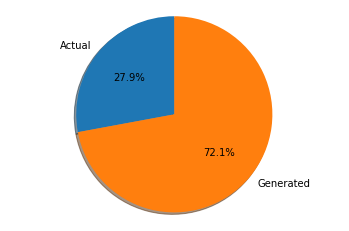

In [82]:
labels = ["Actual", "Generated"]
sizes = [len(actual_stop_closer), len(gen_stop_closer)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct="%1.1f%%",
        shadow=True, startangle=90)
ax1.axis("equal") 

plt.show()

Find the mean distance required to get to the closest actual and generated stops from the list of results.

Actual:

In [58]:
avg_distance_to_actual = results_df["actual_stops_sp_length"].mean()
avg_distance_to_actual

3358.801708661417

3.4km. Now calculate for the generated stops:

In [59]:
avg_distance_to_gen = results_df["gen_stops_sp_length"].mean()
avg_distance_to_gen

2515.077901041667

2.5km. Check the difference:

In [78]:
diff = avg_distance_to_actual-avg_distance_to_gen
avg = (avg_distance_to_actual+avg_distance_to_gen)/2
pct_diff_avg_distance = (diff/avg)*100
pct_diff_avg_distance

28.727991163659517

The generated bus stops are on average 28.7% closer to the sample source nodes

Find the distance covered by the actual and generated bus routes so that fuel requirements can be calculated.

Load the original graph:

In [63]:
routes_graph = ox.load_graphml(filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")
route_nodes, route_edges = ox.graph_to_gdfs(routes_graph)

# string to bool
bool_replace = {"True": True, "False": False}
route_nodes["community_route"] = route_nodes["community_route"].map(bool_replace).fillna(False)
route_nodes["connection_route"] = route_nodes["connection_route"].map(bool_replace).fillna(False)
route_nodes["actual_stop"] = route_nodes["actual_stop"].map(bool_replace).fillna(False)

# ensure ints where expected
route_nodes["community_route_order"] = route_nodes["community_route_order"].astype(int)
route_nodes

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order,highway
2114650326,55.057663,-7.403884,2114650326,0,0.0002304475544637878,POINT (-7.40388 55.05766),0,0,False,32,False,False,NaN,NaN,NaN,NaN
2114650363,55.058671,-7.401458,2114650363,0,0.0005012166713618143,POINT (-7.40146 55.05867),14,0,True,36,False,False,NaN,NaN,NaN,NaN
2114650574,55.065282,-7.431412,2114650574,0,0.00039074531890811445,POINT (-7.43141 55.06528),0,0,True,24,False,False,NaN,NaN,NaN,NaN
2114650603,55.056001,-7.403478,2114650603,0,0.0002147939880001362,POINT (-7.40348 55.05600),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
258442518,55.132364,-7.454354,258442518,0,0.00020807192473270327,POINT (-7.45435 55.13236),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895464217,55.022280,-8.301011,1895464217,9,0.00020824925797252749,POINT (-8.30101 55.02228),0,0,True,44,False,False,NaN,NaN,NaN,NaN
1878490428,54.931667,-8.419818,1878490428,9,0.00028288951702548035,POINT (-8.41982 54.93167),0,0,False,-1,False,False,NaN,NaN,NaN,NaN
1878490444,54.929254,-8.441124,1878490444,9,0.00028813735045901657,POINT (-8.44112 54.92925),0,0,False,-1,False,True,NaN,NaN,LL15-4,NaN
1895464579,55.022001,-8.320247,1895464579,9,0.0001534778486489186,POINT (-8.32025 55.02200),0,0,False,36,False,False,NaN,NaN,NaN,NaN


Generated routes

Community:

Get community route nodes and sort by route order

In [64]:
community_labels = list(route_nodes["community"].unique())
community_labels = [x for x in community_labels if str(x) != "nan"]
community_labels

['0', '1', '10', '11', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

In [65]:
community_route_nodes = []
for label in community_labels:
    nodes = route_nodes[(route_nodes["community"] == label) &
                        (route_nodes["community_route_order"] != -1)]
    nodes = nodes.sort_values(by="community_route_order")
    print(nodes)
    community_route_nodes.append(nodes)
len(community_route_nodes)

                    y         x       osmid community                    rank  \
262459232   55.116530 -7.460112   262459232         0   0.0006952453004233725   
2110993824  55.108519 -7.468899  2110993824         0  0.00012637731175985182   
2112562727  55.104847 -7.472255  2112562727         0  0.00019422346858492885   
2112562550  55.104540 -7.472658  2112562550         0  0.00023191885408507408   
258440720   55.102323 -7.475625   258440720         0  0.00025243842682268344   
2112562637  55.099784 -7.477446  2112562637         0  0.00026320998428031267   
2112562834  55.098461 -7.477632  2112562834         0   0.0002677939289857593   
2114692416  55.090521 -7.477590  2114692416         0   0.0002678747581426052   
258430807   55.090303 -7.477391   258430807         0   0.0002635385422318902   
2739577689  55.088130 -7.473974  2739577689         0   0.0002530695079664303   
2114692276  55.087741 -7.472854  2114692276         0    0.000233162586979399   
1979831232  55.087395 -7.471

14

Get the path of each community route

In [66]:
community_route_paths = [nodes["osmid"].tolist() for nodes in community_route_nodes]
len(community_route_paths)

14

Connections:

Get connection route nodes and sort by route order


In [67]:
connection_labels = ["a", "b", "c", "d"]
connection_route_nodes = []
connections = route_nodes[~route_nodes["connection"].isna()]
for label in connection_labels:
    nodes = connections[connections["connection"].str.contains(label)]
    # get correct connection order
    nodes["connection_order"] = nodes["connection_order"].str.extract(fr'{label}-(\d+)').astype(int)
    nodes.sort_values(by="connection_order", inplace=True)
    print(len(nodes))
    print(nodes)
    connection_route_nodes.append(nodes)
len(connection_route_nodes)

111
                    y         x       osmid community                    rank  \
2031126838  54.700451 -8.714760  2031126838         4   0.0006252125397542372   
507651123   54.706136 -8.724546   507651123         4  0.00018472189722861063   
1279748374  54.706386 -8.723325  1279748374         4  0.00017664263353640952   
2031154660  54.706664 -8.721967  2031154660         4   0.0002892484220071071   
1994336918  54.708648 -8.718380  1994336918         4  0.00023710239609514865   
...               ...       ...         ...       ...                     ...   
2012372598  54.835305 -8.442197  2012372598         5  0.00018460086528664015   
3578705391  54.836965 -8.444232  3578705391         5  0.00017134918887561234   
1956322707  54.836991 -8.444260  1956322707         5  0.00011978364995745125   
324742301   54.837298 -8.444637   324742301         5   0.0005905778203008173   
504701424   54.838289 -8.452235   504701424         5   0.0005909948387135886   

                       

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
<ipython-input-67-fa2ca40f5574>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes.sort_values(by="connection_order", inplace=True)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

4

Get the path of each connection route

In [68]:
connection_route_paths = [nodes["osmid"].tolist() for nodes in connection_route_nodes]
len(connection_route_paths)

4

In [134]:
all_gen_paths = community_route_paths + connection_route_paths
gen_path_lengths = [route_helper.path_weight(routes_graph, path, weight="length")
                    for path in all_gen_paths]
total_distance_generated = sum(gen_path_lengths)
total_distance_generated

804324.4140000001

Now finding the distance covered by the 23 actual bus routes

First need to find paths between the stops and combine them to give entire route

In [72]:
actual_stops = route_nodes[route_nodes["actual_stop"] == True]

route_num = 11
a = actual_stops["actual_route_order"].str.extract(fr'LL{route_num}-(\d+)')

actual_routes = []
for i in range(1, 24):
    nodes = actual_stops[actual_stops["actual_route_order"].str.contains(f"LL{i}-")]
    nodes["actual_route"] = i
    nodes["order"] = nodes["actual_route_order"].str.extract(fr'LL{i}\-(\d+)').astype(int)
    nodes = nodes.sort_values(by="order")
    print(len(nodes))
    print(nodes)
    actual_routes.append(nodes)
sum(len(route) for route in actual_routes)

2
                    y         x       osmid community                    rank  \
843310079   55.251139 -7.261558   843310079         1  0.00027770146572002173   
1924390314  55.189202 -7.038989  1924390314         1   0.0002614244613985181   

                             geometry top_n route_flag  community_route  \
843310079   POINT (-7.26156 55.25114)     0          0            False   
1924390314  POINT (-7.03899 55.18920)     0          0            False   

            community_route_order  connection_route  actual_stop connection  \
843310079                      -1             False         True        NaN   
1924390314                     88             False         True        NaN   

           connection_order     actual_route_order highway  actual_route  \
843310079               NaN  LL1-2, LL12-1, LL13-1     NaN             1   
1924390314              NaN          LL1-3, LL11-1     NaN             1   

            order  
843310079       2  
1924390314      3  
9

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingW

154

Create a list of the actual route paths

In [73]:
actual_route_paths = [nodes["osmid"].tolist() for nodes in actual_routes]

Find the paths between those nodes in the actual routes

In [74]:
all_actual_paths = []
i = 1
for route in actual_route_paths:
    try:
        paths = [nx.shortest_path(routes_graph, u, v, weight="length") for (u, v) in zip(route, route[1:])]
        all_actual_paths.append(paths)
    except:
        print(f"Failed to find path for route: {i}")
    i += 1

Failed to find path for route: 8
Failed to find path for route: 9


Routes 8 and 9 failed so need to investigate those:

Plot the failed route nodes:

<GeoAxesSubplot:>

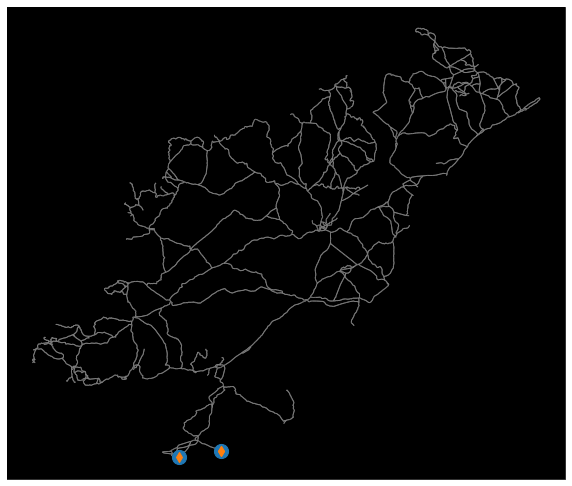

In [105]:
edges = ox.graph_to_gdfs(routes_graph, nodes=False)
nodes_route9 = [1278531552, 1945739836]
no_path_route9 = actual_stops[(actual_stops["osmid"] == nodes_route9[0]) |
                       (actual_stops["osmid"] == nodes_route9[1])]
nodes_route8 = [1278531558, 1278531552, 1945739836]
no_path_route8 = actual_stops[(actual_stops["osmid"] == nodes_route8[0]) |
                              (actual_stops["osmid"] == nodes_route8[1]) |
                              (actual_stops["osmid"] == nodes_route8[2])]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

no_path_route9.plot(
    ax=ax,
    marker="o",
    markersize=200,
    zorder=2,
    categorical=True
)

no_path_route8.plot(
    ax=ax,
    marker="d",
    markersize=50,
    zorder=2,
    categorical=True
)

Route 8 and 9 share nodes and are at the bottom of the graph, they likely cross into Leitrim.

Moving ahead without including them. Combine the lists of intermediate paths

In [76]:
combined_actual_paths = []
for route in all_actual_paths:
    full_path = sum(route, [])
    # remove sequential duplicates, they are there
    # because nodes are start and end points of the calculated paths
    prev = object()
    full_path = [prev:=v for v in full_path if prev!=v]
    combined_actual_paths.append(full_path)
len(combined_actual_paths)

21

Find total length of actual routes:

In [132]:
actual_path_lengths = [route_helper.path_weight(routes_graph, path, weight="length") 
                       for path in combined_actual_paths]
total_distance_actual = sum(actual_path_lengths)
total_distance_actual

731526.074

Using the data recorded by Ivkovic et al. (2017) for the average fuel consumption by diesel buses in Serbia in 2014 (23.78L per 100km), estimations of the fuel required by both bus networks will be calculated. Price of diesel being used based on data by the AA (https://www.theaa.ie/aa/motoring-advice/petrol-prices.aspx) is 117.3c per litre. Using 3 return trips (i.e 6 lengths of the each route) per route as a daily estimate.

Find consumption per km:

In [110]:
per_l = 117.3
per_km = 28.78/100
per_km

0.2878

Calculate fuel required to drive each route once...

Generated routes:

In [135]:
fuel_per_gen_routes = []
i = 1
for gen_route in gen_path_lengths:
    route_in_km = gen_route/1000
    print(f"-------------------\nGenerated route {i}\n-------------------\nDistance: {round(route_in_km, 2)}km")
    fuel_required = route_in_km*per_km
    print(f"Fuel per trip: {round(fuel_required, 2)}L")
    cost = (fuel_required*per_l)/100
    print(f"Cost per trip: €{round(cost, 2)}")
    daily_cost = cost*6
    print(f"Estimated daily: €{round(daily_cost, 2)}")
    yearly_cost = daily_cost*364
    print(f"Estimated yearly: €{round(yearly_cost, 2)}\n")
    fuel_per_gen_routes.append(yearly_cost)
    i += 1
estimated_cost_total_generated = sum(fuel_per_gen_routes)

-------------------
Generated route 1
-------------------
Distance: 19.58km
Fuel per trip: 5.63L
Cost per trip: €6.61
Estimated daily: €39.65
Estimated yearly: €14432.69

-------------------
Generated route 2
-------------------
Distance: 61.15km
Fuel per trip: 17.6L
Cost per trip: €20.65
Estimated daily: €123.87
Estimated yearly: €45089.28

-------------------
Generated route 3
-------------------
Distance: 25.29km
Fuel per trip: 7.28L
Cost per trip: €8.54
Estimated daily: €51.23
Estimated yearly: €18647.18

-------------------
Generated route 4
-------------------
Distance: 33.38km
Fuel per trip: 9.61L
Cost per trip: €11.27
Estimated daily: €67.62
Estimated yearly: €24613.31

-------------------
Generated route 5
-------------------
Distance: 27.34km
Fuel per trip: 7.87L
Cost per trip: €9.23
Estimated daily: €55.38
Estimated yearly: €20159.27

-------------------
Generated route 6
-------------------
Distance: 44.6km
Fuel per trip: 12.84L
Cost per trip: €15.06
Estimated daily: €90.34

In [128]:
estimated_cost_total_generated

593024.5695795037

Actual:

In [133]:
fuel_per_actual_routes = []
i = 1
for act_route in actual_path_lengths:
    route_in_km = act_route/1000
    print(f"-------------------\nActual route {i}\n-------------------\nDistance: {round(route_in_km, 2)}km")
    fuel_required = route_in_km*per_km
    print(f"Fuel per trip: {round(fuel_required, 2)}L")
    cost = (fuel_required*per_l)/100
    print(f"Cost per trip: €{round(cost, 2)}")
    daily_cost = cost*6
    print(f"Estimated daily: €{round(daily_cost, 2)}")
    yearly_cost = daily_cost*364
    print(f"Estimated yearly: €{round(yearly_cost, 2)}\n")
    fuel_per_actual_routes.append(yearly_cost)
    i += 1
estimated_cost_total_actual = sum(fuel_per_actual_routes)

-------------------
Actual route 1
-------------------
Distance: 18.25km
Fuel per trip: 5.25L
Cost per trip: €6.16
Estimated daily: €36.97
Estimated yearly: €13457.25

-------------------
Actual route 2
-------------------
Distance: 71.98km
Fuel per trip: 20.72L
Cost per trip: €24.3
Estimated daily: €145.8
Estimated yearly: €53071.02

-------------------
Actual route 3
-------------------
Distance: 38.18km
Fuel per trip: 10.99L
Cost per trip: €12.89
Estimated daily: €77.33
Estimated yearly: €28146.9

-------------------
Actual route 4
-------------------
Distance: 52.38km
Fuel per trip: 15.07L
Cost per trip: €17.68
Estimated daily: €106.09
Estimated yearly: €38617.76

-------------------
Actual route 5
-------------------
Distance: 31.16km
Fuel per trip: 8.97L
Cost per trip: €10.52
Estimated daily: €63.11
Estimated yearly: €22970.79

-------------------
Actual route 6
-------------------
Distance: 64.29km
Fuel per trip: 18.5L
Cost per trip: €21.7
Estimated daily: €130.23
Estimated year

In [130]:
estimated_cost_total_actual

539350.6993187381

Check the percentage difference in estimated cost:

In [131]:
diff = estimated_cost_total_generated - estimated_cost_total_actual
avg = (estimated_cost_total_generated + estimated_cost_total_actual)/2
pct_diff_cost = (diff/avg)*100
pct_diff_cost

9.479873277873386